In [1]:
import torch
torch.cuda.is_available()

True

In [2]:
import json
import os
from collections import defaultdict
import torch.nn as nn
import torch
import torch.nn.functional as F
import math,copy,re
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch.cuda.amp import autocast, GradScaler
from tqdm.notebook import tqdm
warnings.simplefilter("ignore")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Transformer Architecture 

## Positional Encoding
![title](imgs/Positional_Encoding.png)

In [3]:
#adds position data to input
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_len):
        super(PositionalEncoding, self).__init__()
        self.d_model = d_model 

        position = torch.arange(0, max_seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        pe = torch.zeros(max_seq_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term) #even indices use sine
        pe[:, 1::2] = torch.cos(position * div_term) #odd use cos
        
        pe = pe.unsqueeze(0) #adds dimension for batch

        self.register_buffer('pe', pe) #doesn't get updated during backpropagation

    def forward(self, x):
        seq_len = x.size(1) #x has shape [batch_size, seq_len, d_model]
        x = x + self.pe[:, :seq_len] #adds positional encoding till seq_len (as x is seq_len)
        return x

## Multi Head Attention
![title](imgs/Multi_Head_Attention.png)

In [4]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__() # Initializes nn.Module
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads" #to make sure dimension of all heads are the same
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads  # Dimension of each head's key/query/value
        
        # Linear projections for Q, K, V, and output (dimensions are d_model and not d_k as weights of all heads are contained in this)
        self.W_q = nn.Linear(d_model, d_model, bias=False)  # Query projection
        self.W_k = nn.Linear(d_model, d_model, bias=False)  # Key projection
        self.W_v = nn.Linear(d_model, d_model, bias=False)  # Value projection
        self.W_o = nn.Linear(d_model, d_model, bias=False)  # Output projection
        
        # Initialize parameters with Xavier initialization
        nn.init.xavier_uniform_(self.W_q.weight)
        nn.init.xavier_uniform_(self.W_k.weight)
        nn.init.xavier_uniform_(self.W_v.weight)
        nn.init.xavier_uniform_(self.W_o.weight)
        
    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        # Compute attention scores (Q * K^T / sqrt(d_k))
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        
        # Apply mask if provided (for padding tokens or future tokens)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)
        
        # Apply softmax to get attention weights
        attn_probs = F.softmax(attn_scores, dim=-1)
        
        # Apply attention weights to values
        output = torch.matmul(attn_probs, V)
        
        return output
        
    def split_heads(self, x):
        batch_size, seq_length, _ = x.size()

        #changes shape from [batch_size, seq_len, d_model] to [batch_size, num_heads, seq_len, d_k]
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)
        
    def combine_heads(self, x):
        batch_size, _, seq_length, _ = x.size()

        #changes shape from [batch_size, num_heads, seq_len, d_k] to [batch_size, seq_len, d_model]
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)
        
    def forward(self, Q, K, V, mask=None):
        # Linear projections and split into heads
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))
        
        # Scaled dot-product attention
        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)
        
        # Concatenate heads and apply final linear layer
        output = self.W_o(self.combine_heads(attn_output))
        
        return output

## Position Wise Feed Forward
![title](imgs/FFN.png)

In [5]:
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionWiseFeedForward, self).__init__()
        # 2 Linear Layers, Dropout and ReLU
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        
        # Initialize parameters
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.zeros_(self.fc1.bias)
        nn.init.zeros_(self.fc2.bias)

    def forward(self, x):
        return self.fc2(self.dropout(self.relu(self.fc1(x))))

## Encoder Layer
![title](imgs/Encoder.png)

In [6]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model, eps=1e-6)
        self.norm2 = nn.LayerNorm(d_model, eps=1e-6)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        
    def forward(self, x, mask):
        # Self-attention block with residual connection and layer norm
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout1(attn_output))
        
        # Feed-forward block with residual connection and layer norm
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout2(ff_output))
        
        return x

## Decoder Layer
![title](imgs/Decoder.png)

In [7]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff, dropout)
        
        self.norm1 = nn.LayerNorm(d_model, eps=1e-6)
        self.norm2 = nn.LayerNorm(d_model, eps=1e-6)
        self.norm3 = nn.LayerNorm(d_model, eps=1e-6)
        
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)
        
    def forward(self, x, enc_output, src_mask, tgt_mask):
        # Masked self-attention block
        attn_output = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout1(attn_output))
        
        # Cross-attention block
        attn_output = self.cross_attn(x, enc_output, enc_output, src_mask)
        x = self.norm2(x + self.dropout2(attn_output))
        
        # Feed-forward block
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout3(ff_output))
        
        return x

## Transformer
![title](imgs/Model_Arch.png)

In [8]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout):
        super(Transformer, self).__init__()
        self.d_model = d_model
        self.max_seq_length = max_seq_length
        
        # Embeddings and positional encoding
        self.encoder_embedding = nn.Embedding(src_vocab_size, d_model)
        self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length * 2)
        
        # Encoder and decoder stacks
        self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        
        # Final output layer
        self.fc = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)
        
        # Initialize parameters
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def generate_mask(self, src, tgt):
        # Source mask hides padding tokens
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
        
        # Target mask hides padding tokens and future tokens
        tgt_mask = (tgt != 0).unsqueeze(1).unsqueeze(3) #for padding
        seq_length = tgt.size(1)
        nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length, device=src.device), diagonal=1)).bool() #for future tokens
        tgt_mask = tgt_mask & nopeak_mask
        
        return src_mask, tgt_mask

    def forward(self, src, tgt):
        src_mask, tgt_mask = self.generate_mask(src, tgt)
        
        # Embed source tokens and add positional encoding
        src_embedded = self.encoder_embedding(src) * math.sqrt(self.d_model)
        src_embedded = self.dropout(self.positional_encoding(src_embedded))
        
        # Embed target tokens and add positional encoding
        tgt_embedded = self.decoder_embedding(tgt) * math.sqrt(self.d_model)
        tgt_embedded = self.dropout(self.positional_encoding(tgt_embedded))

        # Encoder forward pass
        enc_output = src_embedded
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output, src_mask)

        # Decoder forward pass
        dec_output = tgt_embedded
        for dec_layer in self.decoder_layers:
            dec_output = dec_layer(dec_output, enc_output, src_mask, tgt_mask)

        # Final linear projection
        output = self.fc(dec_output) 
        return output

    def generate(self, src, sos_token, eos_token, max_length=None):
        if max_length is None:
            max_length = self.max_seq_length
            
        self.eval() 
        batch_size = src.size(0)
        device = src.device
        
        # Generate encoder output
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
        src_embedded = self.encoder_embedding(src) * math.sqrt(self.d_model)
        src_embedded = self.positional_encoding(src_embedded)
        
        enc_output = src_embedded
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output, src_mask)
        
        # Initialize decoder with SOS tokens
        decoder_input = torch.full((batch_size, 1), sos_token, dtype=torch.long, device=device)
        
        # Generate output sequence autoregressively
        for _ in range(max_length - 1):  # -1 to account for the SOS token
            # Generate target mask for current sequence
            tgt_mask = (decoder_input != 0).unsqueeze(1).unsqueeze(3)
            seq_len = decoder_input.size(1)
            nopeak_mask = (1 - torch.triu(torch.ones(1, seq_len, seq_len, device=device), diagonal=1)).bool()
            tgt_mask = tgt_mask & nopeak_mask
            
            # Forward pass through decoder
            tgt_embedded = self.decoder_embedding(decoder_input) * math.sqrt(self.d_model)
            tgt_embedded = self.positional_encoding(tgt_embedded)
            
            dec_output = tgt_embedded
            for dec_layer in self.decoder_layers:
                dec_output = dec_layer(dec_output, enc_output, src_mask, tgt_mask)
            
            # Get next token probabilities
            logits = self.fc(dec_output[:, -1, :])
            probs = F.softmax(logits, dim=-1)
            
            # Get the most likely next token (greedy)
            _, next_token = torch.max(probs, dim=-1, keepdim=True)
            
            # Concatenate to decoder input
            decoder_input = torch.cat([decoder_input, next_token], dim=1)
            
            # Stop if all sequences have generated EOS
            if (next_token == eos_token).all():
                break
        
        return decoder_input

    def tokenize_input(self, text, vocab):
        tokens = [vocab.get(c, vocab['<unk>']) for c in text]
        tokens = tokens[:self.max_seq_length] + [vocab['<pad>']] * (self.max_seq_length - len(tokens))
        return torch.tensor(tokens, dtype=torch.long).unsqueeze(0)  # Add batch dimension
    
    def detokenize_output(self, tensor, inv_vocab):
        # Convert tensor to text, stopping at EOS token
        result = []
        for idx in tensor[0]:
            token = inv_vocab.get(idx.item(), '<unk>')
            if token == '<eos>':
                break
            result.append(token)
        return ''.join(result)

# Testing Transformer

In [9]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import math
import random

class AdditionDataset(Dataset):
    def __init__(self, num_samples, max_digits):
        self.num_samples = num_samples
        self.max_digits = max_digits
        self.src_max_len = 2 * max_digits + 1  # e.g., "123+456" is 7 chars
        self.tgt_max_len = max_digits + 1 + 2  # e.g., "<sos>579<eos>" is 6 chars
        self.vocab = {
            '<pad>': 0, '<sos>': 1, '<eos>': 2, '<unk>': -1, '+': 3,
            '0':4, '1':5, '2':6, '3':7, '4':8, '5':9, '6':10, '7':11, '8':12, '9':13
        }
        self.inv_vocab = {v:k for k,v in self.vocab.items()}

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        max_val = 10**self.max_digits - 1
        a = random.randint(0, max_val)
        b = random.randint(0, max_val)
        src_str = f"{a}+{b}"
        tgt_str = f"{a + b}"

        # Convert source to indices and pad
        src = [self.vocab[c] for c in src_str]
        src = src + [self.vocab['<pad>']] * (self.src_max_len - len(src))
        
        # Convert target to indices (with <sos> and <eos>) and pad
        tgt = [self.vocab['<sos>']] + [self.vocab[c] for c in tgt_str] + [self.vocab['<eos>']]
        tgt = tgt + [self.vocab['<pad>']] * (self.tgt_max_len - len(tgt))
        
        return torch.tensor(src), torch.tensor(tgt)

    # def __getitem__(self, idx):
    #     max_val = 10**self.max_digits - 1
    #     a = random.randint(0, max_val)
    #     b = random.randint(0, max_val)
    #     src_str = f"{a:0{self.max_digits}d}+{b:0{self.max_digits}d}"
    #     tgt_str = f"{a+b:0{self.max_digits+1}d}"  # Allow for carry

    #     # Convert source to indices and pad
    #     src = [self.vocab[c] for c in src_str]
    #     src = src + [self.vocab['<pad>']] * (self.src_max_len - len(src))
        
    #     # Convert target to indices (with <sos> and <eos>) and pad
    #     tgt = [self.vocab['<sos>']] + [self.vocab[c] for c in tgt_str] + [self.vocab['<eos>']]
    #     tgt = tgt + [self.vocab['<pad>']] * (self.tgt_max_len - len(tgt))
        
    #     return torch.tensor(src), torch.tensor(tgt)

In [10]:
# Model configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
max_digits = 2  # 2-digit numbers
src_vocab_size = 15  # Includes digits, operations, and special tokens
tgt_vocab_size = 15

# Architecture parameters
d_model = 256  # Embedding dimension
num_heads = 8   # Number of attention heads
num_layers = 6  # Number of encoder/decoder layers
d_ff = 1024     # Feed-forward hidden dimension
max_seq_length = 2 * max_digits + 1  # For positional encoding
dropout = 0.1   # Dropout rate

# Training parameters
batch_size = 128
num_epochs = 20  
n_samples = 50000
learning_rate = 0.0005

# Initialize model
model = Transformer(
    src_vocab_size, tgt_vocab_size, d_model, num_heads,
    num_layers, d_ff, max_seq_length, dropout
).to(device)

# Initialize datasets and dataloaders
train_dataset = AdditionDataset(num_samples=n_samples, max_digits=max_digits)
val_dataset = AdditionDataset(num_samples=1000, max_digits=max_digits)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=0)  # Ignore padding tokens
optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=learning_rate, 
    betas=(0.9, 0.98), 
    eps=1e-9
)

# Learning rate scheduler with warmup
class NoamScheduler:    
    def __init__(self, optimizer, d_model, warmup_steps=4000):
        self.optimizer = optimizer
        self.d_model = d_model
        self.warmup_steps = warmup_steps
        self.current_step = 0
        
    def step(self):
        self.current_step += 1
        lr = self.get_lr()
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr
            
    def get_lr(self):
        step = max(1, self.current_step)
        factor = min(step ** (-0.5), step * self.warmup_steps ** (-1.5))
        return factor * (self.d_model ** (-0.5))

# Create scheduler
scheduler = NoamScheduler(optimizer, d_model, warmup_steps=4000)

Starting training on cuda...
Model architecture: d_model=256, heads=8, layers=6, ff_dim=1024


Epoch 1/20:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 1/20 completed
  Train Loss: 1.9437
  Val Loss:   1.2034
  Val Acc:    55.61%
  New best model saved! (accuracy: 55.61%)


Epoch 2/20:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2/20 completed
  Train Loss: 1.1690
  Val Loss:   0.9006
  Val Acc:    64.78%
  New best model saved! (accuracy: 64.78%)


Epoch 3/20:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 3/20 completed
  Train Loss: 0.9100
  Val Loss:   0.7099
  Val Acc:    72.14%
  New best model saved! (accuracy: 72.14%)


Epoch 4/20:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 4/20 completed
  Train Loss: 0.7621
  Val Loss:   0.6520
  Val Acc:    74.75%
  New best model saved! (accuracy: 74.75%)


Epoch 5/20:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 5/20 completed
  Train Loss: 0.5110
  Val Loss:   0.1987
  Val Acc:    93.38%
  New best model saved! (accuracy: 93.38%)


Epoch 6/20:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 6/20 completed
  Train Loss: 0.2478
  Val Loss:   0.1665
  Val Acc:    95.09%
  New best model saved! (accuracy: 95.09%)


Epoch 7/20:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 7/20 completed
  Train Loss: 0.1914
  Val Loss:   0.0710
  Val Acc:    97.60%
  New best model saved! (accuracy: 97.60%)


Epoch 8/20:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 8/20 completed
  Train Loss: 0.1293
  Val Loss:   0.0377
  Val Acc:    98.89%
  New best model saved! (accuracy: 98.89%)


Epoch 9/20:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 9/20 completed
  Train Loss: 0.1546
  Val Loss:   0.0450
  Val Acc:    98.62%


Epoch 10/20:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 10/20 completed
  Train Loss: 0.1356
  Val Loss:   0.0343
  Val Acc:    98.89%


Epoch 11/20:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 11/20 completed
  Train Loss: 0.4574
  Val Loss:   1.3412
  Val Acc:    35.01%


Epoch 12/20:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 12/20 completed
  Train Loss: 0.6107
  Val Loss:   5.3654
  Val Acc:    33.62%


Epoch 13/20:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 13/20 completed
  Train Loss: 0.2122
  Val Loss:   6.2131
  Val Acc:    32.78%


Epoch 14/20:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 14/20 completed
  Train Loss: 0.1725
  Val Loss:   5.6324
  Val Acc:    33.64%


Epoch 15/20:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 15/20 completed
  Train Loss: 0.1421
  Val Loss:   6.1298
  Val Acc:    33.58%


Epoch 16/20:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 16/20 completed
  Train Loss: 0.1093
  Val Loss:   6.0117
  Val Acc:    34.15%


Epoch 17/20:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 17/20 completed
  Train Loss: 0.0888
  Val Loss:   6.3127
  Val Acc:    34.13%


Epoch 18/20:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 18/20 completed
  Train Loss: 0.1118
  Val Loss:   5.8558
  Val Acc:    33.87%


Epoch 19/20:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 19/20 completed
  Train Loss: 0.1056
  Val Loss:   6.6283
  Val Acc:    33.93%


Epoch 20/20:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 20/20 completed
  Train Loss: 0.0802
  Val Loss:   6.3094
  Val Acc:    33.67%

Training completed!
Best validation accuracy: 98.89%


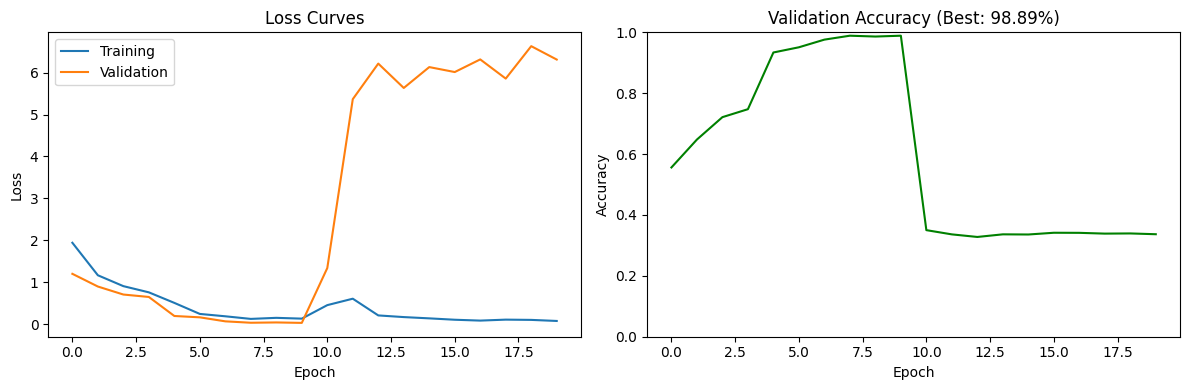

In [11]:
def compute_accuracy(output, target):
    pred = output.argmax(dim=-1)
    mask = (target != 0)  # Ignore padding
    correct = (pred == target) & mask
    return correct.sum().item() / mask.sum().item()

# Training and validation loop
best_accuracy = 0.0
train_losses, val_losses, val_accuracies = [], [], []

print(f"Starting training on {device}...")
print(f"Model architecture: d_model={d_model}, heads={num_heads}, layers={num_layers}, ff_dim={d_ff}")

for epoch in range(num_epochs):
    # Training phase
    model.train()
    total_loss = 0
    
    # Create tqdm progress bar for batches
    batch_iterator = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    
    for batch_idx, (src, tgt) in enumerate(batch_iterator):
        src, tgt = src.to(device), tgt.to(device)
        tgt_input = tgt[:, :-1]  # Exclude <eos>
        tgt_output = tgt[:, 1:]   # Exclude <sos>

        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        output = model(src, tgt_input)
        
        # Calculate loss
        loss = criterion(output.reshape(-1, tgt_vocab_size), tgt_output.reshape(-1))
        
        # Backward pass and optimize
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        
        # Update statistics
        total_loss += loss.item()
        batch_iterator.set_postfix({"loss": f"{loss.item():.4f}"})

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    
    # Validation phase
    model.eval()
    val_loss = 0
    val_acc = 0
    
    with torch.no_grad():
        for src, tgt in val_loader:
            src, tgt = src.to(device), tgt.to(device)
            tgt_input = tgt[:, :-1]
            tgt_output = tgt[:, 1:]
            
            # Forward pass
            output = model(src, tgt_input)
            
            # Calculate loss and accuracy
            loss = criterion(output.reshape(-1, tgt_vocab_size), tgt_output.reshape(-1))
            val_loss += loss.item()
            val_acc += compute_accuracy(output, tgt_output)
    
    avg_val_loss = val_loss / len(val_loader)
    avg_val_acc = val_acc / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_acc)
    
    # Print epoch statistics
    print(f"Epoch {epoch+1}/{num_epochs} completed")
    print(f"  Train Loss: {avg_loss:.4f}")
    print(f"  Val Loss:   {avg_val_loss:.4f}")
    print(f"  Val Acc:    {avg_val_acc:.2%}")
    
    # Save best model
    if avg_val_acc > best_accuracy:
        best_accuracy = avg_val_acc
        torch.save(model.state_dict(), "best_addition_transformer.pt")
        print(f"  New best model saved! (accuracy: {best_accuracy:.2%})")

# Print final results
print("\nTraining completed!")
print(f"Best validation accuracy: {best_accuracy:.2%}")

# Plot training curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training')
plt.plot(val_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'Validation Accuracy (Best: {best_accuracy:.2%})')
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

In [12]:
# Load the best model for inference
try:
    model.load_state_dict(torch.load("best_addition_transformer.pt"))
    print("Loaded best model with validation accuracy:", best_accuracy)
except FileNotFoundError:
    print("Using final model from training")

# Define vocabulary
vocab = train_dataset.vocab
inv_vocab = train_dataset.inv_vocab

def predict(model, text_input, verbose=False):
    model.eval()
    
    # Tokenize input
    src_tensor = model.tokenize_input(
        text=text_input, 
        vocab=vocab
    ).to(device)
    
    # Generate output sequence
    output = model.generate(
        src=src_tensor,
        sos_token=vocab['<sos>'],
        eos_token=vocab['<eos>'],
    )
    
    # Convert output tokens to string
    prediction = model.detokenize_output(output, inv_vocab).replace('<sos>', '')
    
    # Parse input to check correctness
    nums = text_input.split('+')
    if len(nums) == 2:
        try:
            num1, num2 = int(nums[0]), int(nums[1])
            expected = str(num1 + num2)
            correct = prediction == expected
            if verbose:
                print(f"Input: {text_input}")
                print(f"Predicted: {prediction}")
                print(f"Expected: {expected}")
                print(f"Correct: {correct}")
            return prediction, correct
        except ValueError:
            pass
    
    return prediction, None

Loaded best model with validation accuracy: 0.9889284592150253


In [16]:
# Test the model on various examples
test_cases = [
    "1+2",
    "99+96",
    "42+57",
    "10+23",
    "88+2",
    "11+11",
    "10+10",
    "80+77",
    "50+50",
    "69+39"
]

correct_count = 0
results = []

print("Testing the model on various addition problems:\n")
print("{:<10} {:<10} {:<10} {:<10}".format("Input", "Predicted", "Expected", "Correct"))
print("-" * 40)

for test_input in test_cases:
    prediction, correct = predict(model, test_input)
    
    # Calculate expected result
    nums = test_input.split('+')
    num1, num2 = int(nums[0]), int(nums[1])
    expected = str(num1 + num2)
    
    # Update statistics
    if correct:
        correct_count += 1
    
    results.append((test_input, prediction, expected, correct))
    
    # Print formatted results
    check_mark = "✓" if correct else "✗"
    print("{:<10} {:<10} {:<10} {:<10}".format(test_input, prediction, expected, check_mark))

print("\nAccuracy on test cases: {:.0%}".format(correct_count / len(test_cases)))

# Create a more comprehensive test set
print("\nRunning a larger test set...")
num_eval_samples = 1000

eval_correct = 0
for _ in range(num_eval_samples):
    a = random.randint(0, 99)
    b = random.randint(0, 99)
    test_input = f"{a}+{b}"
    
    prediction, correct = predict(model, test_input)
    if correct:
        eval_correct += 1

print(f"Accuracy on {num_eval_samples} random test cases: {eval_correct/num_eval_samples:.2%}")

Testing the model on various addition problems:

Input      Predicted  Expected   Correct   
----------------------------------------
1+2        23         3          ✗         
99+96      195        195        ✓         
42+57      99         99         ✓         
10+23      43         33         ✗         
88+2       90         90         ✓         
11+11      22         22         ✓         
10+10      20         20         ✓         
80+77      157        157        ✓         
50+50      100        100        ✓         
69+39      108        108        ✓         

Accuracy on test cases: 80%

Running a larger test set...
Accuracy on 1000 random test cases: 96.20%
